# Project 8: Backtesting

In this project, you will build a fairly realistic backtester that uses the Barra data. The backtester will perform portfolio optimization that includes transaction costs, and you'll implement it with computational efficiency in mind, to allow for a reasonably fast backtest. You'll also use performance attribution to identify the major drivers of your portfolio's profit-and-loss (PnL). You will have the option to modify and customize the backtest as well.


## Instructions

Each problem consists of a function to implement and instructions on how to implement the function.  The parts of the function that need to be implemented are marked with a `# TODO` comment. Your code will be checked for the correct solution when you submit it to Udacity.


## Packages

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages will be imported for you. We recommend you don't add any import statements, otherwise the grader might not be able to run your code.

### Install Packages

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

    100% |████████████████████████████████| 17.3MB 2.1MB/s eta 0:00:01   39% |████████████▊                   | 6.9MB 35.0MB/s eta 0:00:01    49% |███████████████▊                | 8.5MB 33.4MB/s eta 0:00:01    76% |████████████████████████▋       | 13.3MB 32.5MB/s eta 0:00:01    94% |██████████████████████████████▎ | 16.4MB 32.9MB/s eta 0:00:01
    100% |████████████████████████████████| 10.1MB 5.6MB/s eta 0:00:01   35% |███████████▎                    | 3.5MB 31.6MB/s eta 0:00:01    80% |█████████████████████████▉      | 8.1MB 28.9MB/s eta 0:00:01    96% |██████████████████████████████▊ | 9.7MB 32.5MB/s eta 0:00:01
    100% |████████████████████████████████| 235kB 22.3MB/s ta 0:00:01
    100% |████████████████████████████████| 48.2MB 769kB/s eta 0:00:01  1% |▋                               | 839kB 28.3MB/s eta 0:00:02    4% |█▌                              | 2.3MB 30.7MB/s eta 0:00:02    16% |█████▍                          | 8.1MB 28.4MB/s eta 0:00:02    59% |██████████████████▉    

### Load Packages

In [2]:
import scipy
import patsy
import pickle

import numpy as np
import pandas as pd

import scipy.sparse
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 8)

from statistics import median
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols
from tqdm import tqdm

## Load Data

We’ll be using the Barra dataset to get factors that can be used to predict risk. Loading and parsing the raw Barra data can be a very slow process that can significantly slow down your backtesting. For this reason, it's important to pre-process the data beforehand. For your convenience, the Barra data has already been pre-processed for you and saved into pickle files. You will load the Barra data from these pickle files.

In the code below, we start by loading `2004` factor data from the `pandas-frames.2004.pickle` file. We also load the `2003` and `2004` covariance data from the `covaraince.2003.pickle`  and `covaraince.2004.pickle` files. You are encouraged  to customize the data range for your backtest. For example, we recommend starting with two or three years of factor data. Remember that the covariance data should include all the years that you choose for the factor data,   and also one year earlier. For example, in the code below we are using  `2004` factor data, therefore, we must include `2004` in our covariance data, but also the previous year, `2003`. If you don't remember why must include this previous year, feel free to review the lessons.

In [3]:
barra_dir = '../../data/project_8_barra/'

data = {}
for year in [2004]:
    fil = barra_dir + "pandas-frames." + str(year) + ".pickle"
    data.update(pickle.load( open( fil, "rb" ) ))
    
covariance = {}
for year in [2004]:
    fil = barra_dir + "covariance." + str(year) + ".pickle"
    covariance.update(pickle.load( open(fil, "rb" ) ))
    
daily_return = {}
for year in [2004, 2005]:
    fil = barra_dir + "price." + str(year) + ".pickle"
    daily_return.update(pickle.load( open(fil, "rb" ) ))

In [4]:
data

{'20040102':         Barrid  USFASTD_1DREVRSL  USFASTD_AERODEF  USFASTD_AIRLINES  \
 0      USA0001            -0.032            0.000               0.0   
 1      USA0011            -0.059            0.000               0.0   
 2      USA0031             0.457            0.000               0.0   
 3      USA0062            -0.128            0.431               0.0   
 4      USA00E2             0.374            0.000               0.0   
 5      USA00F1            -0.254            0.000               0.0   
 6      USA00G2            -0.317            0.000               0.0   
 7      USA00H1             0.157            0.000               0.0   
 8      USA00I1            -0.550            0.000               0.0   
 9      USA00J1            -0.169            0.000               0.0   
 10     USA00K1            -1.019            0.000               0.0   
 11     USA00P1             0.334            0.000               0.0   
 12     USA00R1             0.490            0.000  

In [5]:
data.keys()

dict_keys(['20040102', '20040105', '20040106', '20040107', '20040108', '20040109', '20040112', '20040113', '20040114', '20040115', '20040116', '20040120', '20040121', '20040122', '20040123', '20040126', '20040127', '20040128', '20040129', '20040130', '20040202', '20040203', '20040204', '20040205', '20040206', '20040209', '20040210', '20040211', '20040212', '20040213', '20040217', '20040218', '20040219', '20040220', '20040223', '20040224', '20040225', '20040226', '20040227', '20040301', '20040302', '20040303', '20040304', '20040305', '20040308', '20040309', '20040310', '20040311', '20040312', '20040315', '20040316', '20040317', '20040318', '20040319', '20040322', '20040323', '20040324', '20040325', '20040326', '20040329', '20040330', '20040331', '20040401', '20040402', '20040405', '20040406', '20040407', '20040408', '20040412', '20040413', '20040414', '20040415', '20040416', '20040419', '20040420', '20040421', '20040422', '20040423', '20040426', '20040427', '20040428', '20040429', '2004

In [6]:
data['20040102'].head()

Barrid  USFASTD_1DREVRSL  USFASTD_AERODEF  USFASTD_AIRLINES  \
0  USA0001            -0.032            0.000               0.0   
1  USA0011            -0.059            0.000               0.0   
2  USA0031             0.457            0.000               0.0   
3  USA0062            -0.128            0.431               0.0   
4  USA00E2             0.374            0.000               0.0   

   USFASTD_ALUMSTEL  USFASTD_APPAREL  USFASTD_AUTO  USFASTD_BANKS  \
0               0.0              0.0           0.0            0.0   
1               0.0              0.0           0.0            0.0   
2               0.0              0.0           0.0            0.0   
3               0.0              0.0           0.0            0.0   
4               0.0              0.0           0.0            0.0   

   USFASTD_BETA  USFASTD_BEVTOB  ...  BidAskSpread  DailyVolume  ADTCA_30  \
0        -2.177             0.0  ...           NaN          NaN       NaN   
1        -2.176             0.0  ...           NaN          NaN       NaN   
2        -2.061             0.0  ...           NaN          NaN       NaN   
3        -2.003             0.0  ...           NaN          NaN       NaN   
4        -1.967             0.0  ...           NaN          NaN       NaN   

   IssuerMarketCap     Yield  TotalRisk   SpecRisk  HistBeta  PredBeta  \
0     5.392988e+10  0.188679  13.959397   9.014505 -0.000189  0.156387   
1     5.874999e+09  0.000000  17.033359  11.726327  0.000013  0.147900   
2     7.304963e+10  2.103004  21.738218  18.047415  0.053033  0.216422   
3     2.866562e+10  2.243494  23.129496  20.830128  0.079755  0.355564   
4     5.720420e+10  2.167256  25.391653  21.458171  0.096238  0.412602   

   DataDate  
0  20040102  
1  20040102  
2  20040102  
3  20040102  
4  20040102  

[5 rows x 92 columns]

In [7]:
data['20040102'].shape

(12442, 92)

In [8]:
covariance

{'20040102':                Factor1           Factor2    VarCovar  DataDate
 0     USFASTD_1DREVRSL  USFASTD_1DREVRSL    1.958869  20040102
 1     USFASTD_1DREVRSL      USFASTD_BETA    1.602458  20040102
 2     USFASTD_1DREVRSL   USFASTD_DIVYILD   -0.012642  20040102
 3     USFASTD_1DREVRSL   USFASTD_DWNRISK   -0.064387  20040102
 4     USFASTD_1DREVRSL  USFASTD_EARNQLTY    0.046573  20040102
 5     USFASTD_1DREVRSL  USFASTD_EARNYILD    0.013229  20040102
 6     USFASTD_1DREVRSL    USFASTD_GROWTH   -0.133492  20040102
 7     USFASTD_1DREVRSL    USFASTD_INDMOM    0.015145  20040102
 8     USFASTD_1DREVRSL  USFASTD_LEVERAGE    0.005025  20040102
 9     USFASTD_1DREVRSL  USFASTD_LIQUIDTY    0.136076  20040102
 10    USFASTD_1DREVRSL  USFASTD_LTREVRSL   -0.083329  20040102
 11    USFASTD_1DREVRSL  USFASTD_MGMTQLTY   -0.034950  20040102
 12    USFASTD_1DREVRSL    USFASTD_MIDCAP   -0.098919  20040102
 13    USFASTD_1DREVRSL  USFASTD_MOMENTUM    0.113221  20040102
 14    USFASTD_1DREVRSL    U

In [9]:
covariance.keys()

dict_keys(['20040102', '20040105', '20040106', '20040107', '20040108', '20040109', '20040112', '20040113', '20040114', '20040115', '20040116', '20040120', '20040121', '20040122', '20040123', '20040126', '20040127', '20040128', '20040129', '20040130', '20040202', '20040203', '20040204', '20040205', '20040206', '20040209', '20040210', '20040211', '20040212', '20040213', '20040217', '20040218', '20040219', '20040220', '20040223', '20040224', '20040225', '20040226', '20040227', '20040301', '20040302', '20040303', '20040304', '20040305', '20040308', '20040309', '20040310', '20040311', '20040312', '20040315', '20040316', '20040317', '20040318', '20040319', '20040322', '20040323', '20040324', '20040325', '20040326', '20040329', '20040330', '20040331', '20040401', '20040402', '20040405', '20040406', '20040407', '20040408', '20040412', '20040413', '20040414', '20040415', '20040416', '20040419', '20040420', '20040421', '20040422', '20040423', '20040426', '20040427', '20040428', '20040429', '2004

In [10]:
covariance['20040102'].head()

Factor1           Factor2  VarCovar  DataDate
0  USFASTD_1DREVRSL  USFASTD_1DREVRSL  1.958869  20040102
1  USFASTD_1DREVRSL      USFASTD_BETA  1.602458  20040102
2  USFASTD_1DREVRSL   USFASTD_DIVYILD -0.012642  20040102
3  USFASTD_1DREVRSL   USFASTD_DWNRISK -0.064387  20040102
4  USFASTD_1DREVRSL  USFASTD_EARNQLTY  0.046573  20040102

In [11]:
covariance['20040102'].shape

(3570, 4)

In [12]:
daily_return

{'20040102':         Barrid  DlyReturn
 76     USA0001   0.000000
 77     USA0011   0.000000
 78     USA0031   0.000000
 79     USA0062   0.000000
 80     USA00E2   0.000000
 81     USA00F1   0.000000
 82     USA00G2   0.000000
 83     USA00H1   0.000000
 84     USA00I1   0.000000
 85     USA00J1   0.000000
 86     USA00K1   0.000000
 87     USA00P1   0.000000
 88     USA00R1   0.000000
 89     USA00S1  -0.009555
 90     USA00V1   0.000000
 91     USA0131   0.000000
 92     USA0161   0.000000
 93     USA01I1   0.000000
 94     USA01J2   0.000000
 95     USA01L1   0.000000
 96     USA01P1   0.000000
 97     USA01Q1   0.000000
 98     USA0202   0.000000
 99     USA0231   0.000000
 100    USA0281   0.000000
 101    USA0291   0.000000
 102    USA02A1   0.000000
 103    USA02B1   0.083078
 104    USA02H1   0.000000
 105    USA02P1   0.000000
 ...        ...        ...
 12488  USAZY41   0.000000
 12489  USAZY51   0.000000
 12490  USAZY61   0.000000
 12491  USAZY71   0.000000
 12492  USAZYI1 

In [13]:
daily_return.keys()

dict_keys(['20040102', '20040105', '20040106', '20040107', '20040108', '20040109', '20040112', '20040113', '20040114', '20040115', '20040116', '20040120', '20040121', '20040122', '20040123', '20040126', '20040127', '20040128', '20040129', '20040130', '20040202', '20040203', '20040204', '20040205', '20040206', '20040209', '20040210', '20040211', '20040212', '20040213', '20040217', '20040218', '20040219', '20040220', '20040223', '20040224', '20040225', '20040226', '20040227', '20040301', '20040302', '20040303', '20040304', '20040305', '20040308', '20040309', '20040310', '20040311', '20040312', '20040315', '20040316', '20040317', '20040318', '20040319', '20040322', '20040323', '20040324', '20040325', '20040326', '20040329', '20040330', '20040331', '20040401', '20040402', '20040405', '20040406', '20040407', '20040408', '20040412', '20040413', '20040414', '20040415', '20040416', '20040419', '20040420', '20040421', '20040422', '20040423', '20040426', '20040427', '20040428', '20040429', '2004

In [14]:
daily_return['20040102'].head()

Barrid  DlyReturn
76  USA0001        0.0
77  USA0011        0.0
78  USA0031        0.0
79  USA0062        0.0
80  USA00E2        0.0

In [15]:
tmp = daily_return['20040102']
tmp.shape

(12442, 2)

## Shift Daily Returns Data (TODO)

In the cell below, we want to incorporate a realistic time delay that exists in live trading, we’ll use a two day delay for the `daily_return` data. That means the `daily_return` should be two days after the data in `data` and `cov_data`. Combine `daily_return` and `data` together in a dict called `frames`.

Since reporting of PnL is usually for the date of the returns, make sure to use the two day delay dates (dates that match the `daily_return`) when building `frames`. This means calling `frames['20040108']` will get you the prices from "20040108" and the data from `data` at "20040106".

Note: We're not shifting `covariance`, since we'll use the "DataDate" field in `frames` to lookup the covariance data. The "DataDate" field contains the date when the `data` in `frames` was recorded. For example, `frames['20040108']` will give you a value of "20040106" for the field "DataDate".

In [16]:
frames ={}
dlyreturn_n_days_delay = 2

# TODO: Implement
date_shifts = zip(
        sorted(data.keys()),
        sorted(daily_return.keys())[dlyreturn_n_days_delay:len(data) + dlyreturn_n_days_delay])

for data_date, price_date in date_shifts:
    frames[price_date] = data[data_date].merge(daily_return[price_date], on='Barrid')

In [17]:
frames.keys()

dict_keys(['20040106', '20040107', '20040108', '20040109', '20040112', '20040113', '20040114', '20040115', '20040116', '20040120', '20040121', '20040122', '20040123', '20040126', '20040127', '20040128', '20040129', '20040130', '20040202', '20040203', '20040204', '20040205', '20040206', '20040209', '20040210', '20040211', '20040212', '20040213', '20040217', '20040218', '20040219', '20040220', '20040223', '20040224', '20040225', '20040226', '20040227', '20040301', '20040302', '20040303', '20040304', '20040305', '20040308', '20040309', '20040310', '20040311', '20040312', '20040315', '20040316', '20040317', '20040318', '20040319', '20040322', '20040323', '20040324', '20040325', '20040326', '20040329', '20040330', '20040331', '20040401', '20040402', '20040405', '20040406', '20040407', '20040408', '20040412', '20040413', '20040414', '20040415', '20040416', '20040419', '20040420', '20040421', '20040422', '20040423', '20040426', '20040427', '20040428', '20040429', '20040430', '20040503', '2004

In [18]:
frames['20040106'].head()

Barrid  USFASTD_1DREVRSL  USFASTD_AERODEF  USFASTD_AIRLINES  \
0  USA0001            -0.032            0.000               0.0   
1  USA0011            -0.059            0.000               0.0   
2  USA0031             0.457            0.000               0.0   
3  USA0062            -0.128            0.431               0.0   
4  USA00E2             0.374            0.000               0.0   

   USFASTD_ALUMSTEL  USFASTD_APPAREL  USFASTD_AUTO  USFASTD_BANKS  \
0               0.0              0.0           0.0            0.0   
1               0.0              0.0           0.0            0.0   
2               0.0              0.0           0.0            0.0   
3               0.0              0.0           0.0            0.0   
4               0.0              0.0           0.0            0.0   

   USFASTD_BETA  USFASTD_BEVTOB  ...  DailyVolume  ADTCA_30  IssuerMarketCap  \
0        -2.177             0.0  ...          NaN       NaN     5.392988e+10   
1        -2.176             0.0  ...          NaN       NaN     5.874999e+09   
2        -2.061             0.0  ...          NaN       NaN     7.304963e+10   
3        -2.003             0.0  ...          NaN       NaN     2.866562e+10   
4        -1.967             0.0  ...          NaN       NaN     5.720420e+10   

      Yield  TotalRisk   SpecRisk  HistBeta  PredBeta  DataDate  DlyReturn  
0  0.188679  13.959397   9.014505 -0.000189  0.156387  20040102        0.0  
1  0.000000  17.033359  11.726327  0.000013  0.147900  20040102        0.0  
2  2.103004  21.738218  18.047415  0.053033  0.216422  20040102        0.0  
3  2.243494  23.129496  20.830128  0.079755  0.355564  20040102        0.0  
4  2.167256  25.391653  21.458171  0.096238  0.412602  20040102        0.0  

[5 rows x 93 columns]

## Add Daily Returns date column (Optional)
Name the column `DlyReturnDate`.
**Hint**: create a list containing copies of the date, then create a pandas series.

In [19]:
daily_return['20040102'].head()

Barrid  DlyReturn
76  USA0001        0.0
77  USA0011        0.0
78  USA0031        0.0
79  USA0062        0.0
80  USA00E2        0.0

In [20]:
# Optional

for DlyReturnDate, df in daily_return.items():
    rows = df.shape[0]
    df['DlyReturnDate'] = pd.Series([DlyReturnDate]*rows)

In [21]:
daily_return['20040102'].head()

Barrid  DlyReturn DlyReturnDate
76  USA0001        0.0      20040102
77  USA0011        0.0      20040102
78  USA0031        0.0      20040102
79  USA0062        0.0      20040102
80  USA00E2        0.0      20040102

## Winsorize

As we have done in other projects, we'll want to avoid extremely positive or negative values in our data. Will therefore create a function, `wins`, that will clip our values to a minimum and maximum range. This process is called **Winsorizing**. Remember that this helps us handle noise, which may otherwise cause unusually large positions.

In [22]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

## Density Plot

Let's check our `wins` function by taking a look at the distribution of returns for a single day `20040102`. We will clip our data from `-0.1` to `0.1` and plot it using our `density_plot` function.

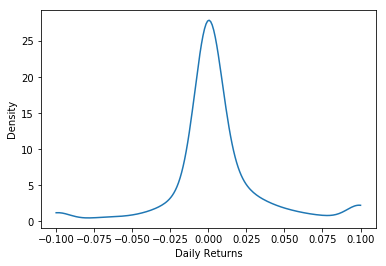

In [23]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()
    
test = frames['20040108']
test['DlyReturn'] = wins(test['DlyReturn'],-0.1,0.1)
density_plot(test['DlyReturn'])

## Factor Exposures and Factor Returns

Recall that:

$r_{i,t} = \sum_{j=1}^{k} (\beta_{i,j,t-2} \times f_{j,t})$  
where $i=1...N$ (N assets),   
and $j=1...k$ (k factors).

where $r_{i,t}$ is the return, $\beta_{i,j,t-2}$ is the factor exposure, and $f_{j,t}$ is the factor return. Since we get the factor exposures from the Barra data, and we know the returns, it is possible to estimate the factor returns. In this notebook, we will use the Ordinary Least Squares (OLS) method to estimate the factor exposures, $f_{j,t}$, by using $\beta_{i,j,t-2}$ as the independent variable, and $r_{i,t}$ as the dependent variable.

In [24]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n):
    return list(filter(lambda x: "USFASTD_" in x, n))

def estimate_factor_returns(df): 
    ## build universe based on filters 
    estu = df.loc[df.IssuerMarketCap > 1e9].copy(deep=True)
  
    ## winsorize returns for fitting 
    estu['DlyReturn'] = wins(estu['DlyReturn'], -0.25, 0.25)
  
    all_factors = factors_from_names(list(df))
    form = get_formula(all_factors, "DlyReturn")
    model = ols(form, data=estu)
    results = model.fit()
    return results

In [25]:
facret = {}

for date in frames:
    facret[date] = estimate_factor_returns(frames[date]).params

In [26]:
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))

## Choose Alpha Factors

We will now choose our alpha factors. Barra's factors include some alpha factors that we have seen before, such as:

* **USFASTD_1DREVRSL** : Reversal

* **USFASTD_EARNYILD** : Earnings Yield

* **USFASTD_VALUE** : Value

* **USFASTD_SENTMT** : Sentiment

We will choose these alpha factors for now, but you are encouraged to come back to this later and try other factors as well.

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


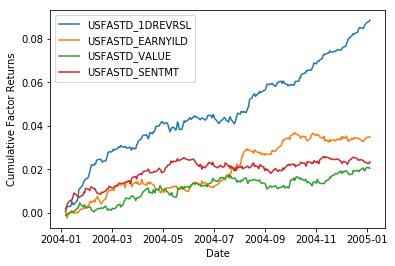

In [27]:
alpha_factors = ["USFASTD_1DREVRSL", "USFASTD_EARNYILD", "USFASTD_VALUE", "USFASTD_SENTMT"]

facret_df = pd.DataFrame(index = my_dates)

for dt in my_dates: 
    for alp in alpha_factors: 
        facret_df.at[dt, alp] = facret[dt.strftime('%Y%m%d')][alp]

for column in facret_df.columns:
        plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

## Merge Previous Portfolio Holdings 

In order to optimize our portfolio we will use the previous day's holdings to estimate the trade size and transaction costs. In order to keep track of the holdings from the previous day we will include a column to hold the portfolio holdings of the previous day. These holdings of all our assets will be initialized to zero when the backtest first starts.

In [28]:
def clean_nas(df): 
    numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    for numeric_column in numeric_columns: 
        df[numeric_column] = np.nan_to_num(df[numeric_column])
    
    return df

In [29]:
previous_holdings = pd.DataFrame(data = {"Barrid" : ["USA02P1"], "h.opt.previous" : np.array(0)})
df = frames[my_dates[0].strftime('%Y%m%d')]

df = df.merge(previous_holdings, how = 'left', on = 'Barrid')
df = clean_nas(df)
df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])

## Build Universe Based on Filters (TODO)

In the cell below, implement the function `get_universe` that creates a stock universe by selecting only those companies that have a market capitalization of at least 1 billion dollars **OR** that are in the previous day's holdings, even if on the current day, the company no longer meets the 1 billion dollar criteria.

When creating the universe, make sure you use the `.copy()` attribute to create a copy of the data. Also, it is very important to make sure that we are not looking at returns when forming the portfolio! to make this impossible, make sure to drop the column containing the daily return.

In [30]:
def get_universe(df):
    """
    Create a stock universe based on filters

    Parameters
    ----------
    df : DataFrame
        All stocks
        
    Returns
    -------
    universe : DataFrame
        Selected stocks based on filters
    """
    
    # TODO: Implement
    universe = df.loc[(df['IssuerMarketCap'] >= 1e9) | (abs(df['h.opt.previous']) > 0)].copy()
    universe = universe.drop(columns = 'DlyReturn')
    
    return universe

universe = get_universe(df)

In [31]:
universe.head()

Barrid  USFASTD_1DREVRSL  USFASTD_AERODEF  USFASTD_AIRLINES  \
0  USA0001            -0.032            0.000               0.0   
1  USA0011            -0.059            0.000               0.0   
2  USA0031             0.457            0.000               0.0   
3  USA0062            -0.128            0.431               0.0   
4  USA00E2             0.374            0.000               0.0   

   USFASTD_ALUMSTEL  USFASTD_APPAREL  USFASTD_AUTO  USFASTD_BANKS  \
0               0.0              0.0           0.0            0.0   
1               0.0              0.0           0.0            0.0   
2               0.0              0.0           0.0            0.0   
3               0.0              0.0           0.0            0.0   
4               0.0              0.0           0.0            0.0   

   USFASTD_BETA  USFASTD_BEVTOB  ...  DailyVolume  ADTCA_30  IssuerMarketCap  \
0        -2.177             0.0  ...          0.0       0.0     5.392988e+10   
1        -2.176             0.0  ...          0.0       0.0     5.874999e+09   
2        -2.061             0.0  ...          0.0       0.0     7.304963e+10   
3        -2.003             0.0  ...          0.0       0.0     2.866562e+10   
4        -1.967             0.0  ...          0.0       0.0     5.720420e+10   

      Yield  TotalRisk   SpecRisk  HistBeta  PredBeta  DataDate  \
0  0.188679  13.959397   9.014505 -0.000189  0.156387  20040102   
1  0.000000  17.033359  11.726327  0.000013  0.147900  20040102   
2  2.103004  21.738218  18.047415  0.053033  0.216422  20040102   
3  2.243494  23.129496  20.830128  0.079755  0.355564  20040102   
4  2.167256  25.391653  21.458171  0.096238  0.412602  20040102   

   h.opt.previous  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  

[5 rows x 93 columns]

In [32]:
date = str(int(universe['DataDate'][1])) 
date

'20040102'

## Factors

We will now extract both the risk factors and alpha factors. We begin by first getting all the factors using the `factors_from_names` function defined previously.

In [33]:
all_factors = factors_from_names(list(universe))

print(len(all_factors))
print(all_factors)

81
['USFASTD_1DREVRSL', 'USFASTD_AERODEF', 'USFASTD_AIRLINES', 'USFASTD_ALUMSTEL', 'USFASTD_APPAREL', 'USFASTD_AUTO', 'USFASTD_BANKS', 'USFASTD_BETA', 'USFASTD_BEVTOB', 'USFASTD_BIOLIFE', 'USFASTD_BLDGPROD', 'USFASTD_CHEM', 'USFASTD_CNSTENG', 'USFASTD_CNSTMACH', 'USFASTD_CNSTMATL', 'USFASTD_COMMEQP', 'USFASTD_COMPELEC', 'USFASTD_COMSVCS', 'USFASTD_CONGLOM', 'USFASTD_CONTAINR', 'USFASTD_DISTRIB', 'USFASTD_DIVFIN', 'USFASTD_DIVYILD', 'USFASTD_DWNRISK', 'USFASTD_EARNQLTY', 'USFASTD_EARNYILD', 'USFASTD_ELECEQP', 'USFASTD_ELECUTIL', 'USFASTD_FOODPROD', 'USFASTD_FOODRET', 'USFASTD_GASUTIL', 'USFASTD_GROWTH', 'USFASTD_HLTHEQP', 'USFASTD_HLTHSVCS', 'USFASTD_HOMEBLDG', 'USFASTD_HOUSEDUR', 'USFASTD_INDMACH', 'USFASTD_INDMOM', 'USFASTD_INSURNCE', 'USFASTD_INTERNET', 'USFASTD_LEISPROD', 'USFASTD_LEISSVCS', 'USFASTD_LEVERAGE', 'USFASTD_LIFEINS', 'USFASTD_LIQUIDTY', 'USFASTD_LTREVRSL', 'USFASTD_MEDIA', 'USFASTD_MGDHLTH', 'USFASTD_MGMTQLTY', 'USFASTD_MIDCAP', 'USFASTD_MOMENTUM', 'USFASTD_MULTUTIL', '

We will now create the function `setdiff` to just select the factors that we have not defined as alpha factors

In [34]:
def setdiff(temp1, temp2): 
    s = set(temp2)
    temp3 = [x for x in temp1 if x not in s]
    return temp3

In [35]:
risk_factors = setdiff(all_factors, alpha_factors)

print(len(risk_factors))
print(risk_factors)

77
['USFASTD_AERODEF', 'USFASTD_AIRLINES', 'USFASTD_ALUMSTEL', 'USFASTD_APPAREL', 'USFASTD_AUTO', 'USFASTD_BANKS', 'USFASTD_BETA', 'USFASTD_BEVTOB', 'USFASTD_BIOLIFE', 'USFASTD_BLDGPROD', 'USFASTD_CHEM', 'USFASTD_CNSTENG', 'USFASTD_CNSTMACH', 'USFASTD_CNSTMATL', 'USFASTD_COMMEQP', 'USFASTD_COMPELEC', 'USFASTD_COMSVCS', 'USFASTD_CONGLOM', 'USFASTD_CONTAINR', 'USFASTD_DISTRIB', 'USFASTD_DIVFIN', 'USFASTD_DIVYILD', 'USFASTD_DWNRISK', 'USFASTD_EARNQLTY', 'USFASTD_ELECEQP', 'USFASTD_ELECUTIL', 'USFASTD_FOODPROD', 'USFASTD_FOODRET', 'USFASTD_GASUTIL', 'USFASTD_GROWTH', 'USFASTD_HLTHEQP', 'USFASTD_HLTHSVCS', 'USFASTD_HOMEBLDG', 'USFASTD_HOUSEDUR', 'USFASTD_INDMACH', 'USFASTD_INDMOM', 'USFASTD_INSURNCE', 'USFASTD_INTERNET', 'USFASTD_LEISPROD', 'USFASTD_LEISSVCS', 'USFASTD_LEVERAGE', 'USFASTD_LIFEINS', 'USFASTD_LIQUIDTY', 'USFASTD_LTREVRSL', 'USFASTD_MEDIA', 'USFASTD_MGDHLTH', 'USFASTD_MGMTQLTY', 'USFASTD_MIDCAP', 'USFASTD_MOMENTUM', 'USFASTD_MULTUTIL', 'USFASTD_OILGSCON', 'USFASTD_OILGSDRL', '

We will also save the column that contains the previous holdings in a separate variable because we are going to use it later when we perform our portfolio optimization.

In [36]:
h0 = universe['h.opt.previous']

## Matrix of Risk Factor Exposures

Our dataframe contains several columns that we'll use as risk factors exposures.  Extract these and put them into a matrix.

The data, such as industry category, are already one-hot encoded, but if this were not the case, then using `patsy.dmatrices` would help, as this function extracts categories and performs the one-hot encoding.  We'll practice using this package, as you may find it useful with future data sets.  You could also store the factors in a dataframe if you prefer.

#### How to use patsy.dmatrices

`patsy.dmatrices` takes in a formula and the dataframe.  The formula tells the function which columns to take.  The formula will look something like this:  
`SpecRisk ~ 0 + USFASTD_AERODEF + USFASTD_AIRLINES + ...`  
where the variable to the left of the ~ is the "dependent variable" and the others to the right are the independent variables (as if we were preparing data to be fit to a model).

This just means that the `pasty.dmatrices` function will return two matrix variables, one that contains the single column for the dependent variable `outcome`, and the independent variable columns are stored in a matrix `predictors`.

The `predictors` matrix will contain the matrix of risk factors, which is what we want.  We don't actually need the `outcome` matrix; it's just created because that's the way patsy.dmatrices works.

In [37]:
formula = get_formula(risk_factors, "SpecRisk")

In [38]:
def model_matrix(formula, data): 
    outcome, predictors = patsy.dmatrices(formula, data)
    return predictors

In [39]:
B = model_matrix(formula, universe)
BT = B.transpose()

## Calculate Specific Variance

Notice that the specific risk data is in percent:

In [40]:
universe['SpecRisk'][0:2]

0     9.014505
1    11.726327
Name: SpecRisk, dtype: float64

Therefore, in order to get the specific variance for each stock in the universe we first need to multiply these values by `0.01`  and then square them:

In [41]:
specVar = (0.01 * universe['SpecRisk']) ** 2

## Factor covariance matrix (TODO)

Note that we already have factor covariances from Barra data, which is stored in the variable `covariance`.  `covariance` is a dictionary, where the key is each day's date, and the value is a dataframe containing the factor covariances.

In [42]:
covariance['20040102'].head()

Factor1           Factor2  VarCovar  DataDate
0  USFASTD_1DREVRSL  USFASTD_1DREVRSL  1.958869  20040102
1  USFASTD_1DREVRSL      USFASTD_BETA  1.602458  20040102
2  USFASTD_1DREVRSL   USFASTD_DIVYILD -0.012642  20040102
3  USFASTD_1DREVRSL   USFASTD_DWNRISK -0.064387  20040102
4  USFASTD_1DREVRSL  USFASTD_EARNQLTY  0.046573  20040102

In the code below, implement the function `diagonal_factor_cov` to create the factor covariance matrix. Note that the covariances are given in percentage units squared.  Therefore you must re-scale them appropriately so that they're in decimals squared. Use the given `colnames` function to get the column names from `B`. 

When creating factor covariance matrix, you can store the factor variances and covariances, or just store the factor variances.  Try both, and see if you notice any differences.

In [43]:
def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

In [44]:
def diagonal_factor_cov(date, B):
    """
    Create the factor covariance matrix

    Parameters
    ----------
    date : string
           date. For example 20040102
        
    B : patsy.design_info.DesignMatrix OR pandas.core.frame.DataFrame
        Matrix of Risk Factors
        
    Returns
    -------
    Fm : Numpy ndarray
        factor covariance matrix
    """
    
    # TODO: Implement
    cv = covariance[date]
    k = np.shape(B)[1]
    Fm = np.zeros([k,k])
    
    for j in range(0,k): 
        fac = colnames(B)[j]
        Fm[j,j] = (0.01**2) * (cv.loc[(cv.Factor1==fac) & (cv.Factor2==fac),"VarCovar"].iloc[0])

    return(Fm)

Fvar = diagonal_factor_cov(date, B)

## Transaction Costs

To get the transaction cost, or slippage, we have to multiply the price change due to market impact by the amount of dollars traded:

$$
\mbox{tcost_{i,t}} = \% \Delta \mbox{price}_{i,t} \times \mbox{trade}_{i,t}
$$

In summation notation it looks like this:  
$$
\mbox{tcost}_{i,t} = \sum_i^{N} \lambda_{i,t} (h_{i,t} - h_{i,t-1})^2
$$  
where
$$
\lambda_{i,t} = \frac{1}{10\times \mbox{ADV}_{i,t}}
$$

Note that since we're dividing by ADV, we'll want to handle cases when ADV is missing or zero.  In those instances, we can set ADV to a small positive number, such as 10,000, which, in practice assumes that the stock is illiquid. In the code below if there is no volume information we assume the asset is illiquid.

In [45]:
def get_lambda(universe, composite_volume_column = 'ADTCA_30'):
    universe.loc[np.isnan(universe[composite_volume_column]), composite_volume_column] = 1.0e4
    universe.loc[universe[composite_volume_column] == 0, composite_volume_column] = 1.0e4 

    adv = universe[composite_volume_column]
    
    return 0.1 / adv

Lambda = get_lambda(universe)

## Alpha Combination (TODO)

In the code below create a matrix of alpha factors and return it from the function `get_B_alpha`. Create this matrix in the same way you created the matrix of risk factors, i.e. using the `get_formula` and `model_matrix` functions we have defined above. Feel free to go back and look at the previous code.

In [46]:
def get_B_alpha(alpha_factors, universe):
    # TODO: Implement
    B_alpha = model_matrix(get_formula(alpha_factors, "SpecRisk"), data = universe)
    
    return B_alpha

B_alpha = get_B_alpha(alpha_factors, universe)

Now that you have the matrix containing the alpha factors we will combine them by adding its rows. By doing this we will collapse the `B_alpha` matrix into a single alpha vector. We'll multiply by `1e-4` so that the expression of expected portfolio return, $\alpha^T \mathbf{h}$, is in dollar units. 

In [47]:
def get_alpha_vec(B_alpha):
    """
    Create an alpha vecrtor

    Parameters
    ----------        
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    Returns
    -------
    alpha_vec : patsy.design_info.DesignMatrix 
        alpha vecrtor
    """
    
    # TODO: Implement
    scale = 1e-4
    alpha_vec = scale * np.sum(B_alpha, axis=1)
    
    print(alpha_vec.shape)
    
    return alpha_vec


alpha_vec = get_alpha_vec(B_alpha)

(2265,)


#### Optional Challenge

You can also try to a more sophisticated method of alpha combination, by choosing the holding for each alpha based on the same metric of its performance, such as the factor returns, or sharpe ratio.  To make this more realistic, you can calculate a rolling average of the sharpe ratio, which is updated for each day.  Remember to only use data that occurs prior to the date of each optimization, and not data that occurs in the future.  Also, since factor returns and sharpe ratios may be negative, consider using a `max` function to give the holdings a lower bound of zero.

## Objective function (TODO)

The objective function is given by:

$$
f(\mathbf{h}) = \frac{1}{2}\kappa \mathbf{h}_t^T\mathbf{Q}^T\mathbf{Q}\mathbf{h}_t + \frac{1}{2} \kappa \mathbf{h}_t^T \mathbf{S} \mathbf{h}_t - \mathbf{\alpha}^T \mathbf{h}_t + (\mathbf{h}_{t} - \mathbf{h}_{t-1})^T \mathbf{\Lambda} (\mathbf{h}_{t} - \mathbf{h}_{t-1})
$$

Where the terms correspond to: factor risk + idiosyncratic risk - expected portfolio return + transaction costs, respectively. We should also note that $\textbf{Q}^T\textbf{Q}$ is defined to be the same as $\textbf{BFB}^T$.  Review the lessons if you need a refresher of how we get $\textbf{Q}$.

Our objective is to minimize this objective function. To do this, we will use Scipy's optimization function:

`scipy.optimize.fmin_l_bfgs_b(func, initial_guess, func_gradient)`

where:

* **func** : is the function we want to minimize

* **initial_guess** : is out initial guess

* **func_gradient** : is the gradient of the function we want to minimize

So, in order to use the `scipy.optimize.fmin_l_bfgs_b` function we first need to define its parameters.

In the code below implement the function `obj_func(h)` that corresponds to the objective function above that we want to minimize. We will set the risk aversion to be `1.0e-6`.

In [48]:
risk_aversion = 1.0e-6

def get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda): 
    def obj_func(h):
        # TODO: Implement
        f = 0.0
        f += 0.5 * risk_aversion * np.sum( np.matmul(Q, h) ** 2 )
        f += 0.5 * risk_aversion * np.dot(h ** 2, specVar) #since Specific Variance is diagonal, don't have to do matmul
        f -= np.dot(h, alpha_vec)
        f += np.dot( (h - h0) ** 2, Lambda) 
        
        return f
    
    return obj_func

## Gradient (TODO)

Now that we can generate the objective function using `get_obj_func`, we can now create a similar function with its gradient. The reason we're interested in calculating the gradient is so that we can tell the optimizer in which direction, and how much, it should shift the portfolio holdings in order to improve the objective function (minimize variance, minimize transaction cost, and maximize expected portfolio return).

Before we implement the function we first need to know what the gradient looks like. The gradient, or derivative of the objective function, with respect to the portfolio holdings h, is given by:  

$$
f'(\mathbf{h}) = \frac{1}{2}\kappa (2\mathbf{Q}^T\mathbf{Qh}) + \frac{1}{2}\kappa (2\mathbf{Sh}) - \mathbf{\alpha} + 2(\mathbf{h}_{t} - \mathbf{h}_{t-1}) \mathbf{\Lambda}
$$

In the code below, implement the function `grad(h)` that corresponds to the function of the gradient given above.

In [49]:
def get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda):
    def grad_func(h):
        # TODO: Implement
        g = risk_aversion * (np.matmul(QT, np.matmul(Q,h)) + (specVar * h) ) \
        - alpha_vec \
        + 2 * (h-h0) * Lambda 
        
        return (np.asarray(g))
    
    return grad_func


## Optimize (TODO)

Now that we can generate the objective function using `get_obj_func`, and its corresponding gradient using `get_grad_func` we are ready to minimize the objective function using Scipy's optimization function. For this, we will use out initial holdings as our `initial_guess` parameter.

In the cell below, implement the function `get_h_star` that optimizes the objective function. Use the objective function (`obj_func`) and gradient function (`grad_func`) provided within `get_h_star` to optimize the objective function using the `scipy.optimize.fmin_l_bfgs_b` function.

In [50]:
risk_aversion = 1.0e-6

Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
QT = Q.transpose()

def get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda):
    """
    Optimize the objective function

    Parameters
    ----------        
    risk_aversion : int or float 
        Trader's risk aversion
        
    Q : patsy.design_info.DesignMatrix 
        Q Matrix
        
    QT : patsy.design_info.DesignMatrix 
        Transpose of the Q Matrix
        
    specVar: Pandas Series 
        Specific Variance
        
    alpha_vec: patsy.design_info.DesignMatrix 
        alpha vector
        
    h0 : Pandas Series  
        initial holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    optimizer_result[0]: Numpy ndarray 
        optimized holdings
    """
    obj_func = get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda)
    grad_func = get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda)
    
    # TODO: Implement 
    optimizer_result = scipy.optimize.fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)

    return optimizer_result[0]

h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)

After we have optimized our objective function we can now use, `h_star` to create our optimal portfolio:

In [51]:
opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})

## Risk Exposures (TODO)

We can also use `h_star` to calculate our portfolio's risk and alpha exposures.

In the cells below implement the functions `get_risk_exposures` and `get_portfolio_alpha_exposure` that calculate the portfolio's risk and alpha exposures, respectively.

In [52]:
def get_risk_exposures(B, BT, h_star):
    """
    Calculate portfolio's Risk Exposure

    Parameters
    ----------
    B : patsy.design_info.DesignMatrix 
        Matrix of Risk Factors
        
    BT : patsy.design_info.DesignMatrix 
        Transpose of Matrix of Risk Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    risk_exposures : Pandas Series
        Risk Exposures
    """
    
    # TODO: Implement
    risk_exposures = np.matmul(BT, h_star)
    
    return pd.Series(risk_exposures, index = colnames(B))

risk_exposures = get_risk_exposures(B, BT, h_star)

In [53]:
def get_portfolio_alpha_exposure(B_alpha, h_star):
    """
    Calculate portfolio's Alpha Exposure

    Parameters
    ----------
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    alpha_exposures : Pandas Series
        Alpha Exposures
    """
    
    # TODO: Implement
    alpha_exposures = np.matmul(B_alpha.transpose(), h_star)

    return pd.Series(alpha_exposures, index = colnames(B_alpha))


portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)

## Transaction Costs (TODO)

We can also use `h_star` to calculate our total transaction costs:
$$
\mbox{tcost} = \sum_i^{N} \lambda_{i} (h_{i,t} - h_{i,t-1})^2
$$

In the cell below, implement the function `get_total_transaction_costs` that calculates the total transaction costs according to the equation above:

In [54]:
def get_total_transaction_costs(h0, h_star, Lambda):
    """
    Calculate Total Transaction Costs

    Parameters
    ----------
    h0 : Pandas Series
        initial holdings (before optimization)
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    total_transaction_costs : float
        Total Transaction Costs
    """
    
    # TODO: Implement
    total_transaction_costs = np.dot( (h_star - h0) ** 2, Lambda)
    
    return total_transaction_costs

total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)

## Putting It All Together

We can now take all the above functions we created above and use them to create a single function, `form_optimal_portfolio` that returns the optimal portfolio, the risk and alpha exposures, and the total transactions costs.

In [55]:
def form_optimal_portfolio(df, previous, risk_aversion):
    df = df.merge(previous, how = 'left', on = 'Barrid')
    df = clean_nas(df)
    df.loc[df['SpecRisk'] == 0]['SpecRisk'] = median(df['SpecRisk'])
  
    universe = get_universe(df)
    date = str(int(universe['DataDate'][1]))
  
    all_factors = factors_from_names(list(universe))
    risk_factors = setdiff(all_factors, alpha_factors)
  
    h0 = universe['h.opt.previous']
  
    B = model_matrix(get_formula(risk_factors, "SpecRisk"), universe)
    BT = B.transpose()
  
    specVar = (0.01 * universe['SpecRisk']) ** 2
    Fvar = diagonal_factor_cov(date, B)
    
    Lambda = get_lambda(universe)
    B_alpha = get_B_alpha(alpha_factors, universe)
    alpha_vec = get_alpha_vec(B_alpha)
  
    Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
    QT = Q.transpose()
    
    h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda)
    opt_portfolio = pd.DataFrame(data = {"Barrid" : universe['Barrid'], "h.opt" : h_star})
    
    risk_exposures = get_risk_exposures(B, BT, h_star)
    portfolio_alpha_exposure = get_portfolio_alpha_exposure(B_alpha, h_star)
    total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
  
    return {
        "opt.portfolio" : opt_portfolio, 
        "risk.exposures" : risk_exposures, 
        "alpha.exposures" : portfolio_alpha_exposure,
        "total.cost" : total_transaction_costs}

## Build tradelist

The trade list is the most recent optimal asset holdings minus the previous day's optimal holdings.

In [56]:
def build_tradelist(prev_holdings, opt_result):
    tmp = prev_holdings.merge(opt_result['opt.portfolio'], how='outer', on = 'Barrid')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

## Save optimal holdings as previous optimal holdings.

As we walk through each day, we'll re-use the column for previous holdings by storing the "current" optimal holdings as the "previous" optimal holdings.

In [57]:
def convert_to_previous(result): 
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev

## Run the backtest

Walk through each day, calculating the optimal portfolio holdings and trade list.  This may take some time, but should finish sooner if you've chosen all the optimizations you learned in the lessons.

In [58]:
trades = {}
port = {}

for dt in tqdm(my_dates, desc='Optimizing Portfolio', unit='day'):
    date = dt.strftime('%Y%m%d')

    result = form_optimal_portfolio(frames[date], previous_holdings, risk_aversion)
    trades[date] = build_tradelist(previous_holdings, result)
    port[date] = result
    previous_holdings = convert_to_previous(result)

Optimizing Portfolio:   0%|          | 0/252 [00:00<?, ?day/s]

(2265,)


Optimizing Portfolio:   0%|          | 1/252 [00:05<24:01,  5.74s/day]

(2285,)


Optimizing Portfolio:   1%|          | 2/252 [00:11<24:01,  5.77s/day]

(2294,)


Optimizing Portfolio:   1%|          | 3/252 [00:16<22:39,  5.46s/day]

(2301,)


Optimizing Portfolio:   2%|▏         | 4/252 [00:20<21:26,  5.19s/day]

(2308,)


Optimizing Portfolio:   2%|▏         | 5/252 [00:27<22:22,  5.44s/day]

(2315,)


Optimizing Portfolio:   2%|▏         | 6/252 [00:32<22:12,  5.42s/day]

(2324,)


Optimizing Portfolio:   3%|▎         | 7/252 [00:37<22:05,  5.41s/day]

(2328,)


Optimizing Portfolio:   3%|▎         | 8/252 [00:42<21:43,  5.34s/day]

(2330,)


Optimizing Portfolio:   4%|▎         | 9/252 [00:47<21:14,  5.25s/day]

(2332,)


Optimizing Portfolio:   4%|▍         | 10/252 [00:51<20:53,  5.18s/day]

(2341,)


Optimizing Portfolio:   4%|▍         | 11/252 [00:56<20:45,  5.17s/day]

(2357,)


Optimizing Portfolio:   5%|▍         | 12/252 [01:01<20:22,  5.09s/day]

(2361,)


Optimizing Portfolio:   5%|▌         | 13/252 [01:05<20:03,  5.04s/day]

(2366,)


Optimizing Portfolio:   6%|▌         | 14/252 [01:09<19:46,  4.98s/day]

(2370,)


Optimizing Portfolio:   6%|▌         | 15/252 [01:13<19:20,  4.90s/day]

(2374,)


Optimizing Portfolio:   6%|▋         | 16/252 [01:17<19:00,  4.83s/day]

(2375,)


Optimizing Portfolio:   7%|▋         | 17/252 [01:20<18:30,  4.73s/day]

(2374,)


Optimizing Portfolio:   7%|▋         | 18/252 [01:23<18:01,  4.62s/day]

(2373,)


Optimizing Portfolio:   8%|▊         | 19/252 [01:26<17:38,  4.54s/day]

(2375,)


Optimizing Portfolio:   8%|▊         | 20/252 [01:28<17:11,  4.44s/day]

(2377,)


Optimizing Portfolio:   8%|▊         | 21/252 [01:31<16:43,  4.34s/day]

(2382,)


Optimizing Portfolio:   9%|▊         | 22/252 [01:33<16:19,  4.26s/day]

(2384,)


Optimizing Portfolio:   9%|▉         | 23/252 [01:36<15:56,  4.18s/day]

(2385,)


Optimizing Portfolio:  10%|▉         | 24/252 [01:38<15:33,  4.09s/day]

(2386,)


Optimizing Portfolio:  10%|▉         | 25/252 [01:40<15:13,  4.02s/day]

(2387,)


Optimizing Portfolio:  10%|█         | 26/252 [01:45<15:14,  4.04s/day]

(2390,)


Optimizing Portfolio:  11%|█         | 27/252 [01:49<15:12,  4.06s/day]

(2394,)


Optimizing Portfolio:  11%|█         | 28/252 [01:53<15:11,  4.07s/day]

(2398,)


Optimizing Portfolio:  12%|█▏        | 29/252 [01:58<15:08,  4.07s/day]

(2398,)


Optimizing Portfolio:  12%|█▏        | 30/252 [02:02<15:03,  4.07s/day]

(2400,)


Optimizing Portfolio:  12%|█▏        | 31/252 [02:06<15:02,  4.08s/day]

(2401,)


Optimizing Portfolio:  13%|█▎        | 32/252 [02:10<14:58,  4.08s/day]

(2400,)


Optimizing Portfolio:  13%|█▎        | 33/252 [02:14<14:54,  4.08s/day]

(2402,)


Optimizing Portfolio:  13%|█▎        | 34/252 [02:18<14:50,  4.08s/day]

(2403,)


Optimizing Portfolio:  14%|█▍        | 35/252 [02:23<14:47,  4.09s/day]

(2407,)


Optimizing Portfolio:  14%|█▍        | 36/252 [02:27<14:47,  4.11s/day]

(2409,)


Optimizing Portfolio:  15%|█▍        | 37/252 [02:32<14:47,  4.13s/day]

(2410,)


Optimizing Portfolio:  15%|█▌        | 38/252 [02:37<14:46,  4.14s/day]

(2410,)


Optimizing Portfolio:  15%|█▌        | 39/252 [02:41<14:41,  4.14s/day]

(2418,)


Optimizing Portfolio:  16%|█▌        | 40/252 [02:45<14:39,  4.15s/day]

(2421,)


Optimizing Portfolio:  16%|█▋        | 41/252 [02:50<14:37,  4.16s/day]

(2422,)


Optimizing Portfolio:  17%|█▋        | 42/252 [02:55<14:35,  4.17s/day]

(2423,)


Optimizing Portfolio:  17%|█▋        | 43/252 [02:59<14:34,  4.18s/day]

(2427,)


Optimizing Portfolio:  17%|█▋        | 44/252 [03:04<14:34,  4.20s/day]

(2427,)


Optimizing Portfolio:  18%|█▊        | 45/252 [03:09<14:32,  4.22s/day]

(2427,)


Optimizing Portfolio:  18%|█▊        | 46/252 [03:15<14:33,  4.24s/day]

(2427,)


Optimizing Portfolio:  19%|█▊        | 47/252 [03:31<15:23,  4.51s/day]

(2427,)


Optimizing Portfolio:  19%|█▉        | 48/252 [03:36<15:21,  4.52s/day]

(2430,)


Optimizing Portfolio:  19%|█▉        | 49/252 [03:42<15:21,  4.54s/day]

(2430,)


Optimizing Portfolio:  20%|█▉        | 50/252 [03:45<15:12,  4.52s/day]

(2431,)


Optimizing Portfolio:  20%|██        | 51/252 [03:49<15:04,  4.50s/day]

(2434,)


Optimizing Portfolio:  21%|██        | 52/252 [03:51<14:50,  4.45s/day]

(2435,)


Optimizing Portfolio:  21%|██        | 53/252 [03:57<14:52,  4.48s/day]

(2436,)


Optimizing Portfolio:  21%|██▏       | 54/252 [04:00<14:40,  4.45s/day]

(2436,)


Optimizing Portfolio:  22%|██▏       | 55/252 [04:11<15:02,  4.58s/day]

(2436,)


Optimizing Portfolio:  22%|██▏       | 56/252 [04:15<14:55,  4.57s/day]

(2436,)


Optimizing Portfolio:  23%|██▎       | 57/252 [04:18<14:45,  4.54s/day]

(2436,)


Optimizing Portfolio:  23%|██▎       | 58/252 [04:21<14:34,  4.51s/day]

(2436,)


Optimizing Portfolio:  23%|██▎       | 59/252 [04:23<14:22,  4.47s/day]

(2436,)


Optimizing Portfolio:  24%|██▍       | 60/252 [04:26<14:12,  4.44s/day]

(2437,)


Optimizing Portfolio:  24%|██▍       | 61/252 [04:29<14:04,  4.42s/day]

(2436,)


Optimizing Portfolio:  25%|██▍       | 62/252 [04:32<13:54,  4.39s/day]

(2441,)


Optimizing Portfolio:  25%|██▌       | 63/252 [04:42<14:06,  4.48s/day]

(2449,)


Optimizing Portfolio:  25%|██▌       | 64/252 [04:46<14:02,  4.48s/day]

(2451,)


Optimizing Portfolio:  26%|██▌       | 65/252 [04:51<13:59,  4.49s/day]

(2451,)


Optimizing Portfolio:  26%|██▌       | 66/252 [04:55<13:54,  4.48s/day]

(2451,)


Optimizing Portfolio:  27%|██▋       | 67/252 [05:00<13:49,  4.48s/day]

(2450,)


Optimizing Portfolio:  27%|██▋       | 68/252 [05:07<13:50,  4.52s/day]

(2455,)


Optimizing Portfolio:  27%|██▋       | 69/252 [05:12<13:49,  4.53s/day]

(2456,)


Optimizing Portfolio:  28%|██▊       | 70/252 [05:17<13:44,  4.53s/day]

(2456,)


Optimizing Portfolio:  28%|██▊       | 71/252 [05:21<13:39,  4.53s/day]

(2458,)


Optimizing Portfolio:  29%|██▊       | 72/252 [05:28<13:41,  4.56s/day]

(2459,)


Optimizing Portfolio:  29%|██▉       | 73/252 [05:33<13:38,  4.57s/day]

(2460,)


Optimizing Portfolio:  29%|██▉       | 74/252 [05:39<13:35,  4.58s/day]

(2465,)


Optimizing Portfolio:  30%|██▉       | 75/252 [05:43<13:31,  4.58s/day]

(2464,)


Optimizing Portfolio:  30%|███       | 76/252 [05:50<13:31,  4.61s/day]

(2466,)


Optimizing Portfolio:  31%|███       | 77/252 [05:56<13:29,  4.63s/day]

(2468,)


Optimizing Portfolio:  31%|███       | 78/252 [06:01<13:26,  4.64s/day]

(2469,)


Optimizing Portfolio:  31%|███▏      | 79/252 [06:06<13:23,  4.64s/day]

(2469,)


Optimizing Portfolio:  32%|███▏      | 80/252 [06:11<13:19,  4.65s/day]

(2468,)


Optimizing Portfolio:  32%|███▏      | 81/252 [06:17<13:16,  4.66s/day]

(2467,)


Optimizing Portfolio:  33%|███▎      | 82/252 [06:24<13:16,  4.68s/day]

(2467,)


Optimizing Portfolio:  33%|███▎      | 83/252 [06:30<13:15,  4.71s/day]

(2468,)


Optimizing Portfolio:  33%|███▎      | 84/252 [06:35<13:11,  4.71s/day]

(2470,)


Optimizing Portfolio:  34%|███▎      | 85/252 [06:42<13:09,  4.73s/day]

(2472,)


Optimizing Portfolio:  34%|███▍      | 86/252 [06:45<13:02,  4.72s/day]

(2472,)


Optimizing Portfolio:  35%|███▍      | 87/252 [06:48<12:54,  4.69s/day]

(2473,)


Optimizing Portfolio:  35%|███▍      | 88/252 [06:51<12:46,  4.67s/day]

(2473,)


Optimizing Portfolio:  35%|███▌      | 89/252 [06:54<12:39,  4.66s/day]

(2475,)


Optimizing Portfolio:  36%|███▌      | 90/252 [06:57<12:31,  4.64s/day]

(2475,)


Optimizing Portfolio:  36%|███▌      | 91/252 [07:00<12:23,  4.62s/day]

(2475,)


Optimizing Portfolio:  37%|███▋      | 92/252 [07:02<12:15,  4.60s/day]

(2475,)


Optimizing Portfolio:  37%|███▋      | 93/252 [07:06<12:09,  4.59s/day]

(2476,)


Optimizing Portfolio:  37%|███▋      | 94/252 [07:09<12:01,  4.57s/day]

(2477,)


Optimizing Portfolio:  38%|███▊      | 95/252 [07:12<11:55,  4.56s/day]

(2477,)


Optimizing Portfolio:  38%|███▊      | 96/252 [07:16<11:49,  4.55s/day]

(2477,)


Optimizing Portfolio:  38%|███▊      | 97/252 [07:21<11:44,  4.55s/day]

(2479,)


Optimizing Portfolio:  39%|███▉      | 98/252 [07:25<11:39,  4.54s/day]

(2480,)


Optimizing Portfolio:  39%|███▉      | 99/252 [07:27<11:31,  4.52s/day]

(2481,)


Optimizing Portfolio:  40%|███▉      | 100/252 [07:31<11:25,  4.51s/day]

(2482,)


Optimizing Portfolio:  40%|████      | 101/252 [07:35<11:21,  4.51s/day]

(2478,)


Optimizing Portfolio:  40%|████      | 102/252 [07:39<11:16,  4.51s/day]

(2479,)


Optimizing Portfolio:  41%|████      | 103/252 [07:44<11:12,  4.51s/day]

(2484,)


Optimizing Portfolio:  41%|████▏     | 104/252 [07:48<11:07,  4.51s/day]

(2485,)


Optimizing Portfolio:  42%|████▏     | 105/252 [07:53<11:03,  4.51s/day]

(2485,)


Optimizing Portfolio:  42%|████▏     | 106/252 [07:58<10:58,  4.51s/day]

(2485,)


Optimizing Portfolio:  42%|████▏     | 107/252 [08:03<10:55,  4.52s/day]

(2489,)


Optimizing Portfolio:  43%|████▎     | 108/252 [08:08<10:51,  4.52s/day]

(2490,)


Optimizing Portfolio:  43%|████▎     | 109/252 [08:12<10:46,  4.52s/day]

(2490,)


Optimizing Portfolio:  44%|████▎     | 110/252 [08:17<10:42,  4.53s/day]

(2491,)


Optimizing Portfolio:  44%|████▍     | 111/252 [08:25<10:41,  4.55s/day]

(2493,)


Optimizing Portfolio:  44%|████▍     | 112/252 [08:31<10:39,  4.57s/day]

(2494,)


Optimizing Portfolio:  45%|████▍     | 113/252 [08:38<10:37,  4.59s/day]

(2497,)


Optimizing Portfolio:  45%|████▌     | 114/252 [08:47<10:38,  4.63s/day]

(2498,)


Optimizing Portfolio:  46%|████▌     | 115/252 [08:54<10:36,  4.65s/day]

(2499,)


Optimizing Portfolio:  46%|████▌     | 116/252 [09:01<10:34,  4.67s/day]

(2500,)


Optimizing Portfolio:  46%|████▋     | 117/252 [09:08<10:33,  4.69s/day]

(2503,)


Optimizing Portfolio:  47%|████▋     | 118/252 [09:13<10:28,  4.69s/day]

(2507,)


Optimizing Portfolio:  47%|████▋     | 119/252 [09:17<10:23,  4.68s/day]

(2506,)


Optimizing Portfolio:  48%|████▊     | 120/252 [09:23<10:20,  4.70s/day]

(2509,)


Optimizing Portfolio:  48%|████▊     | 121/252 [09:30<10:17,  4.71s/day]

(2507,)


Optimizing Portfolio:  48%|████▊     | 122/252 [09:36<10:14,  4.72s/day]

(2505,)


Optimizing Portfolio:  49%|████▉     | 123/252 [09:42<10:10,  4.73s/day]

(2506,)


Optimizing Portfolio:  49%|████▉     | 124/252 [09:48<10:07,  4.75s/day]

(2507,)


Optimizing Portfolio:  50%|████▉     | 125/252 [09:53<10:03,  4.75s/day]

(2508,)


Optimizing Portfolio:  50%|█████     | 126/252 [09:57<09:57,  4.74s/day]

(2510,)


Optimizing Portfolio:  50%|█████     | 127/252 [10:01<09:52,  4.74s/day]

(2511,)


Optimizing Portfolio:  51%|█████     | 128/252 [10:06<09:47,  4.74s/day]

(2511,)


Optimizing Portfolio:  51%|█████     | 129/252 [10:11<09:43,  4.74s/day]

(2512,)


Optimizing Portfolio:  52%|█████▏    | 130/252 [10:16<09:38,  4.74s/day]

(2514,)


Optimizing Portfolio:  52%|█████▏    | 131/252 [10:20<09:33,  4.74s/day]

(2515,)


Optimizing Portfolio:  52%|█████▏    | 132/252 [10:24<09:27,  4.73s/day]

(2512,)


Optimizing Portfolio:  53%|█████▎    | 133/252 [10:28<09:22,  4.73s/day]

(2514,)


Optimizing Portfolio:  53%|█████▎    | 134/252 [10:32<09:17,  4.72s/day]

(2515,)


Optimizing Portfolio:  54%|█████▎    | 135/252 [10:36<09:11,  4.71s/day]

(2515,)


Optimizing Portfolio:  54%|█████▍    | 136/252 [10:40<09:06,  4.71s/day]

(2516,)


Optimizing Portfolio:  54%|█████▍    | 137/252 [10:44<09:01,  4.71s/day]

(2516,)


Optimizing Portfolio:  55%|█████▍    | 138/252 [10:48<08:55,  4.70s/day]

(2517,)


Optimizing Portfolio:  55%|█████▌    | 139/252 [10:52<08:50,  4.70s/day]

(2517,)


Optimizing Portfolio:  56%|█████▌    | 140/252 [10:56<08:45,  4.69s/day]

(2517,)


Optimizing Portfolio:  56%|█████▌    | 141/252 [11:00<08:40,  4.69s/day]

(2517,)


Optimizing Portfolio:  56%|█████▋    | 142/252 [11:05<08:35,  4.68s/day]

(2516,)


Optimizing Portfolio:  57%|█████▋    | 143/252 [11:09<08:29,  4.68s/day]

(2517,)


Optimizing Portfolio:  57%|█████▋    | 144/252 [11:13<08:24,  4.67s/day]

(2516,)


Optimizing Portfolio:  58%|█████▊    | 145/252 [11:17<08:20,  4.67s/day]

(2518,)


Optimizing Portfolio:  58%|█████▊    | 146/252 [11:22<08:15,  4.67s/day]

(2518,)


Optimizing Portfolio:  58%|█████▊    | 147/252 [11:25<08:09,  4.66s/day]

(2518,)


Optimizing Portfolio:  59%|█████▊    | 148/252 [11:29<08:04,  4.66s/day]

(2519,)


Optimizing Portfolio:  59%|█████▉    | 149/252 [11:33<07:59,  4.65s/day]

(2520,)


Optimizing Portfolio:  60%|█████▉    | 150/252 [11:37<07:54,  4.65s/day]

(2519,)


Optimizing Portfolio:  60%|█████▉    | 151/252 [11:41<07:49,  4.65s/day]

(2520,)


Optimizing Portfolio:  60%|██████    | 152/252 [11:45<07:44,  4.64s/day]

(2520,)


Optimizing Portfolio:  61%|██████    | 153/252 [11:49<07:39,  4.64s/day]

(2519,)


Optimizing Portfolio:  61%|██████    | 154/252 [11:55<07:35,  4.64s/day]

(2518,)


Optimizing Portfolio:  62%|██████▏   | 155/252 [12:01<07:31,  4.65s/day]

(2520,)


Optimizing Portfolio:  62%|██████▏   | 156/252 [12:06<07:26,  4.65s/day]

(2521,)


Optimizing Portfolio:  62%|██████▏   | 157/252 [12:10<07:22,  4.65s/day]

(2521,)


Optimizing Portfolio:  63%|██████▎   | 158/252 [12:15<07:17,  4.65s/day]

(2522,)


Optimizing Portfolio:  63%|██████▎   | 159/252 [12:18<07:12,  4.65s/day]

(2521,)


Optimizing Portfolio:  63%|██████▎   | 160/252 [12:22<07:07,  4.64s/day]

(2523,)


Optimizing Portfolio:  64%|██████▍   | 161/252 [12:30<07:04,  4.66s/day]

(2525,)


Optimizing Portfolio:  64%|██████▍   | 162/252 [12:34<06:59,  4.66s/day]

(2525,)


Optimizing Portfolio:  65%|██████▍   | 163/252 [12:38<06:54,  4.65s/day]

(2525,)


Optimizing Portfolio:  65%|██████▌   | 164/252 [12:42<06:48,  4.65s/day]

(2526,)


Optimizing Portfolio:  65%|██████▌   | 165/252 [12:45<06:43,  4.64s/day]

(2525,)


Optimizing Portfolio:  66%|██████▌   | 166/252 [12:51<06:39,  4.65s/day]

(2526,)


Optimizing Portfolio:  66%|██████▋   | 167/252 [12:56<06:35,  4.65s/day]

(2528,)


Optimizing Portfolio:  67%|██████▋   | 168/252 [13:01<06:30,  4.65s/day]

(2528,)


Optimizing Portfolio:  67%|██████▋   | 169/252 [13:05<06:26,  4.65s/day]

(2529,)


Optimizing Portfolio:  67%|██████▋   | 170/252 [13:11<06:21,  4.66s/day]

(2532,)


Optimizing Portfolio:  68%|██████▊   | 171/252 [13:16<06:17,  4.66s/day]

(2532,)


Optimizing Portfolio:  68%|██████▊   | 172/252 [13:22<06:13,  4.67s/day]

(2533,)


Optimizing Portfolio:  69%|██████▊   | 173/252 [13:28<06:09,  4.67s/day]

(2536,)


Optimizing Portfolio:  69%|██████▉   | 174/252 [13:34<06:05,  4.68s/day]

(2536,)


Optimizing Portfolio:  69%|██████▉   | 175/252 [13:39<06:00,  4.68s/day]

(2537,)


Optimizing Portfolio:  70%|██████▉   | 176/252 [13:45<05:56,  4.69s/day]

(2537,)


Optimizing Portfolio:  70%|███████   | 177/252 [13:50<05:52,  4.69s/day]

(2540,)


Optimizing Portfolio:  71%|███████   | 178/252 [13:58<05:48,  4.71s/day]

(2542,)


Optimizing Portfolio:  71%|███████   | 179/252 [14:04<05:44,  4.72s/day]

(2542,)


Optimizing Portfolio:  71%|███████▏  | 180/252 [14:11<05:40,  4.73s/day]

(2546,)


Optimizing Portfolio:  72%|███████▏  | 181/252 [14:17<05:36,  4.74s/day]

(2547,)


Optimizing Portfolio:  72%|███████▏  | 182/252 [14:22<05:31,  4.74s/day]

(2548,)


Optimizing Portfolio:  73%|███████▎  | 183/252 [14:27<05:27,  4.74s/day]

(2549,)


Optimizing Portfolio:  73%|███████▎  | 184/252 [14:33<05:22,  4.75s/day]

(2548,)


Optimizing Portfolio:  73%|███████▎  | 185/252 [14:39<05:18,  4.75s/day]

(2551,)


Optimizing Portfolio:  74%|███████▍  | 186/252 [14:45<05:14,  4.76s/day]

(2550,)


Optimizing Portfolio:  74%|███████▍  | 187/252 [14:51<05:10,  4.77s/day]

(2550,)


Optimizing Portfolio:  75%|███████▍  | 188/252 [14:58<05:06,  4.78s/day]

(2553,)


Optimizing Portfolio:  75%|███████▌  | 189/252 [15:04<05:01,  4.79s/day]

(2557,)


Optimizing Portfolio:  75%|███████▌  | 190/252 [15:10<04:57,  4.79s/day]

(2557,)


Optimizing Portfolio:  76%|███████▌  | 191/252 [15:16<04:52,  4.80s/day]

(2563,)


Optimizing Portfolio:  76%|███████▌  | 192/252 [15:21<04:48,  4.80s/day]

(2566,)


Optimizing Portfolio:  77%|███████▋  | 193/252 [15:27<04:43,  4.80s/day]

(2568,)


Optimizing Portfolio:  77%|███████▋  | 194/252 [15:33<04:39,  4.81s/day]

(2568,)


Optimizing Portfolio:  77%|███████▋  | 195/252 [15:39<04:34,  4.82s/day]

(2570,)


Optimizing Portfolio:  78%|███████▊  | 196/252 [15:45<04:30,  4.83s/day]

(2569,)


Optimizing Portfolio:  78%|███████▊  | 197/252 [15:51<04:25,  4.83s/day]

(2570,)


Optimizing Portfolio:  79%|███████▊  | 198/252 [15:57<04:21,  4.83s/day]

(2571,)


Optimizing Portfolio:  79%|███████▉  | 199/252 [16:02<04:16,  4.83s/day]

(2572,)


Optimizing Portfolio:  79%|███████▉  | 200/252 [16:05<04:10,  4.83s/day]

(2572,)


Optimizing Portfolio:  80%|███████▉  | 201/252 [16:12<04:06,  4.84s/day]

(2574,)


Optimizing Portfolio:  80%|████████  | 202/252 [16:15<04:01,  4.83s/day]

(2577,)


Optimizing Portfolio:  81%|████████  | 203/252 [16:18<03:56,  4.82s/day]

(2577,)


Optimizing Portfolio:  81%|████████  | 204/252 [16:21<03:50,  4.81s/day]

(2577,)


Optimizing Portfolio:  81%|████████▏ | 205/252 [16:25<03:45,  4.81s/day]

(2581,)


Optimizing Portfolio:  82%|████████▏ | 206/252 [16:29<03:41,  4.81s/day]

(2581,)


Optimizing Portfolio:  82%|████████▏ | 207/252 [16:32<03:35,  4.80s/day]

(2579,)


Optimizing Portfolio:  83%|████████▎ | 208/252 [16:36<03:30,  4.79s/day]

(2580,)


Optimizing Portfolio:  83%|████████▎ | 209/252 [16:40<03:25,  4.79s/day]

(2580,)


Optimizing Portfolio:  83%|████████▎ | 210/252 [16:44<03:20,  4.78s/day]

(2582,)


Optimizing Portfolio:  84%|████████▎ | 211/252 [16:48<03:15,  4.78s/day]

(2585,)


Optimizing Portfolio:  84%|████████▍ | 212/252 [16:51<03:10,  4.77s/day]

(2593,)


Optimizing Portfolio:  85%|████████▍ | 213/252 [16:54<03:05,  4.77s/day]

(2593,)


Optimizing Portfolio:  85%|████████▍ | 214/252 [16:58<03:00,  4.76s/day]

(2594,)


Optimizing Portfolio:  85%|████████▌ | 215/252 [17:04<02:56,  4.76s/day]

(2599,)


Optimizing Portfolio:  86%|████████▌ | 216/252 [17:08<02:51,  4.76s/day]

(2602,)


Optimizing Portfolio:  86%|████████▌ | 217/252 [17:14<02:46,  4.77s/day]

(2604,)


Optimizing Portfolio:  87%|████████▋ | 218/252 [17:21<02:42,  4.78s/day]

(2606,)


Optimizing Portfolio:  87%|████████▋ | 219/252 [17:26<02:37,  4.78s/day]

(2607,)


Optimizing Portfolio:  87%|████████▋ | 220/252 [17:32<02:33,  4.78s/day]

(2608,)


Optimizing Portfolio:  88%|████████▊ | 221/252 [17:36<02:28,  4.78s/day]

(2610,)


Optimizing Portfolio:  88%|████████▊ | 222/252 [17:40<02:23,  4.78s/day]

(2612,)


Optimizing Portfolio:  88%|████████▊ | 223/252 [17:45<02:18,  4.78s/day]

(2613,)


Optimizing Portfolio:  89%|████████▉ | 224/252 [17:50<02:13,  4.78s/day]

(2613,)


Optimizing Portfolio:  89%|████████▉ | 225/252 [17:54<02:08,  4.78s/day]

(2615,)


Optimizing Portfolio:  90%|████████▉ | 226/252 [18:00<02:04,  4.78s/day]

(2618,)


Optimizing Portfolio:  90%|█████████ | 227/252 [18:05<01:59,  4.78s/day]

(2619,)


Optimizing Portfolio:  90%|█████████ | 228/252 [18:12<01:54,  4.79s/day]

(2622,)


Optimizing Portfolio:  91%|█████████ | 229/252 [18:17<01:50,  4.79s/day]

(2624,)


Optimizing Portfolio:  91%|█████████▏| 230/252 [18:25<01:45,  4.81s/day]

(2630,)


Optimizing Portfolio:  92%|█████████▏| 231/252 [18:31<01:41,  4.81s/day]

(2634,)


Optimizing Portfolio:  92%|█████████▏| 232/252 [18:36<01:36,  4.81s/day]

(2637,)


Optimizing Portfolio:  92%|█████████▏| 233/252 [18:41<01:31,  4.81s/day]

(2637,)


Optimizing Portfolio:  93%|█████████▎| 234/252 [18:45<01:26,  4.81s/day]

(2637,)


Optimizing Portfolio:  93%|█████████▎| 235/252 [18:51<01:21,  4.81s/day]

(2637,)


Optimizing Portfolio:  94%|█████████▎| 236/252 [18:55<01:16,  4.81s/day]

(2637,)


Optimizing Portfolio:  94%|█████████▍| 237/252 [19:03<01:12,  4.83s/day]

(2641,)


Optimizing Portfolio:  94%|█████████▍| 238/252 [19:10<01:07,  4.83s/day]

(2640,)


Optimizing Portfolio:  95%|█████████▍| 239/252 [19:18<01:02,  4.85s/day]

(2642,)


Optimizing Portfolio:  95%|█████████▌| 240/252 [19:24<00:58,  4.85s/day]

(2646,)


Optimizing Portfolio:  96%|█████████▌| 241/252 [19:32<00:53,  4.86s/day]

(2649,)


Optimizing Portfolio:  96%|█████████▌| 242/252 [19:40<00:48,  4.88s/day]

(2652,)


Optimizing Portfolio:  96%|█████████▋| 243/252 [19:48<00:44,  4.89s/day]

(2653,)


Optimizing Portfolio:  97%|█████████▋| 244/252 [19:55<00:39,  4.90s/day]

(2653,)


Optimizing Portfolio:  97%|█████████▋| 245/252 [20:03<00:34,  4.91s/day]

(2656,)


Optimizing Portfolio:  98%|█████████▊| 246/252 [20:09<00:29,  4.92s/day]

(2657,)


Optimizing Portfolio:  98%|█████████▊| 247/252 [20:15<00:24,  4.92s/day]

(2658,)


Optimizing Portfolio:  98%|█████████▊| 248/252 [20:22<00:19,  4.93s/day]

(2661,)


Optimizing Portfolio:  99%|█████████▉| 249/252 [20:30<00:14,  4.94s/day]

(2661,)


Optimizing Portfolio:  99%|█████████▉| 250/252 [20:38<00:09,  4.95s/day]

(2662,)


Optimizing Portfolio: 100%|█████████▉| 251/252 [20:45<00:04,  4.96s/day]

(2662,)


Optimizing Portfolio: 100%|██████████| 252/252 [20:54<00:00,  4.98s/day]


## Profit-and-Loss (PnL) attribution (TODO)

Profit and Loss is the aggregate realized daily returns of the assets, weighted by the optimal portfolio holdings chosen, and summed up to get the portfolio's profit and loss.

The PnL attributed to the alpha factors equals the factor returns times factor exposures for the alpha factors.  

$$
\mbox{PnL}_{alpha}= f \times b_{alpha}
$$

Similarly, the PnL attributed to the risk factors equals the factor returns times factor exposures of the risk factors.

$$
\mbox{PnL}_{risk} = f \times b_{risk}
$$

In the code below, in the function `build_pnl_attribution` calculate the PnL attributed to the alpha factors, the PnL attributed to the risk factors, and attribution to cost. 

In [59]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = my_dates)
    
    for dt in my_dates:
        date = dt.strftime('%Y%m%d')

        p = port[date]
        fr = facret[date]

        mf = p['opt.portfolio'].merge(frames[date], how = 'left', on = "Barrid")
        
        mf['DlyReturn'] = wins(mf['DlyReturn'], -0.5, 0.5)
        df.at[dt,"daily.pnl"] = np.sum(mf['h.opt'] * mf['DlyReturn'])
        
        # TODO: Implement
    
        df.at[dt,"attribution.alpha.pnl"] = partial_dot_product(fr, p['alpha.exposures'])
        df.at[dt,"attribution.risk.pnl"] = partial_dot_product(fr, p['risk.exposures'])
        df.at[dt,"attribution.cost"] = p['total.cost']
        
    return df

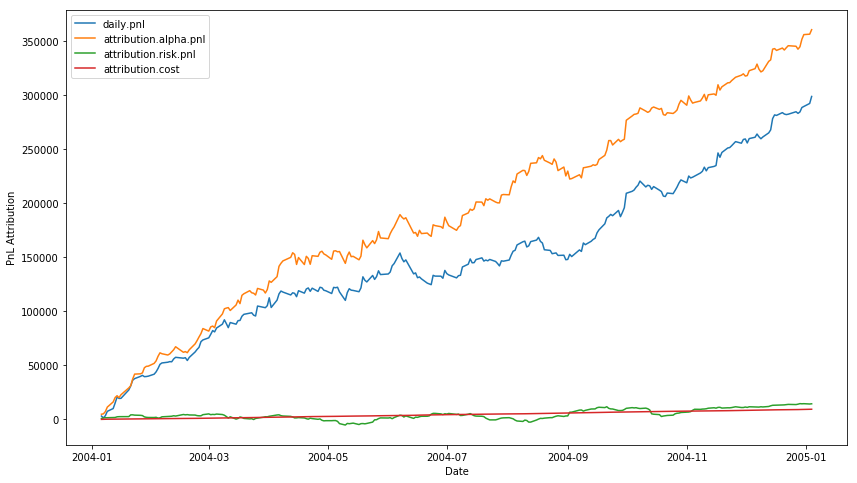

In [66]:
plt.rcParams['figure.figsize'] = (14, 8)

attr = build_pnl_attribution()

for column in attr.columns:
        plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

## Build portfolio characteristics (TODO)
Calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.

In the code below, in the function `build_portfolio_characteristics` calculate the sum of long positions, short positions, net positions, gross market value, and amount of dollars traded.  

In [61]:
def build_portfolio_characteristics(): 
    df = pd.DataFrame(index = my_dates)
    
    for dt in my_dates:
        date = dt.strftime('%Y%m%d')
  
        p = port[date]
        tradelist = trades[date]
        h = p['opt.portfolio']['h.opt']
        
        # TODO: Implement
        
        df.at[dt,"long"] = np.sum(h[h>0])
        df.at[dt,"short"] = np.sum(h[h<0])
        df.at[dt,"net"] = np.sum(h)
        df.at[dt,"gmv"] = np.sum(np.abs(h))
        df.at[dt,"traded"] = np.sum(np.abs(tradelist['h.opt'] - tradelist['h.opt.previous']))

        
    return df

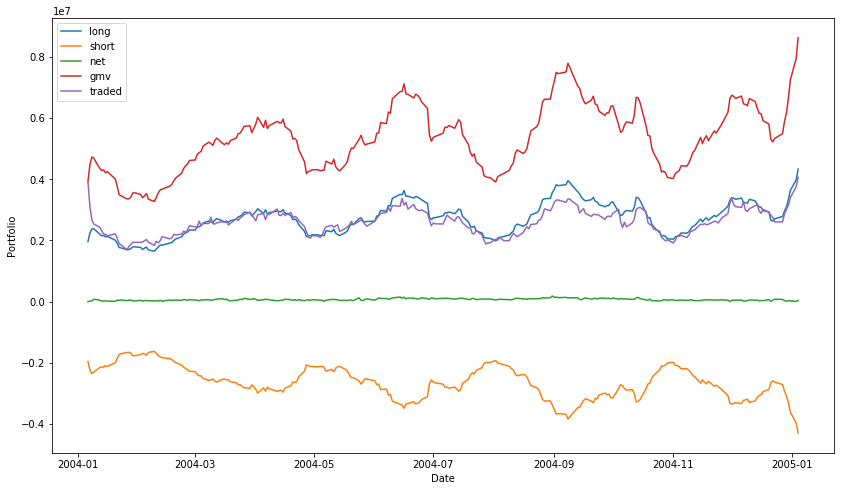

In [65]:
plt.rcParams['figure.figsize'] = (14, 8)

pchar = build_portfolio_characteristics()

for column in pchar.columns:
        plt.plot(pchar[column], label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Portfolio')
plt.show()

#### Optional
Choose additional metrics to evaluate your portfolio.

In [63]:
# Optional


## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade.